Here we want to build a model. We decide on building an LSTM for the following reasons: 
- Need to capture long-term information in the model.
- Other model choices would not be appropriate (due to non-staionary time series).
- Complexity of time series can be properly captured.

We will first build a model for all states, then build a model per state.

In [1]:
import pickle
import polars as pl
import ml_utils
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import holidays
from sklearn.metrics import mean_absolute_error
import constants

In [2]:
with open('blood_donations.pkl', 'rb') as file:
    df = pickle.load(file)

df.head(8)

date,state,a,b,o,ab,all
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3,87
2006-01-02,"""Johor""",4,3,6,2,15
2006-01-03,"""Johor""",2,2,4,0,8
2006-01-04,"""Johor""",7,11,12,3,33
2006-01-05,"""Johor""",3,8,8,1,20
2006-01-06,"""Johor""",2,0,2,0,4
2006-01-07,"""Johor""",1,0,0,0,1
2006-01-08,"""Johor""",20,27,30,9,86


In [3]:
df = df.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

df.head(8)

date,state,a,b,o,ab,all,weekday,month,day_of_year
date,str,i64,i64,i64,i64,i64,i8,i8,i16
2006-01-01,"""Johor""",19,20,45,3,87,7,1,1
2006-01-02,"""Johor""",4,3,6,2,15,1,1,2
2006-01-03,"""Johor""",2,2,4,0,8,2,1,3
2006-01-04,"""Johor""",7,11,12,3,33,3,1,4
2006-01-05,"""Johor""",3,8,8,1,20,4,1,5
2006-01-06,"""Johor""",2,0,2,0,4,5,1,6
2006-01-07,"""Johor""",1,0,0,0,1,6,1,7
2006-01-08,"""Johor""",20,27,30,9,86,7,1,8


In [4]:
# Starting with all
df_all = df.group_by(['date']).agg([
    pl.sum('all').alias('all'),
    pl.first('weekday').alias('weekday'),
    pl.first('month').alias('month'),
    pl.first('day_of_year').alias('day_of_year')
]).sort('date')

df_all.head(8)

date,all,weekday,month,day_of_year
date,i64,i8,i8,i16
2006-01-01,525,7,1,1
2006-01-02,227,1,1,2
2006-01-03,112,2,1,3
2006-01-04,391,3,1,4
2006-01-05,582,4,1,5
2006-01-06,324,5,1,6
2006-01-07,118,6,1,7
2006-01-08,795,7,1,8


In [5]:
holiday_data = [
    {"date": date, "name": name} for date, name in 
    holidays.country_holidays('MY', years=range(2006, 2026)).items()
]

malaysia_holidays_df = pl.DataFrame(holiday_data).filter(pl.col("name") != "Cuti tambahan sempena memperingati SAT 2017")
malaysia_holidays_df

date,name
date,str
2006-01-29,"""Tahun Baharu Cina"""
2006-01-30,"""Tahun Baharu Cina (Hari Kedua)"""
2006-05-12,"""Hari Wesak"""
2006-05-01,"""Hari Pekerja"""
2006-06-03,"""Hari Keputeraan Rasmi Seri Pad…"
…,…
2025-09-05,"""Hari Keputeraan Nabi Muhammad …"
2025-03-31,"""Hari Raya Puasa"""
2025-04-01,"""Hari Raya Puasa (Hari Kedua)"""


In [ ]:
malaysia_holidays_df = malaysia_holidays_df.with_columns(
    pl.col("name").str.replace(r"\s*\(Hari Kedua\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace(r"\s*\(pergantian hari\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace(r"\s*\(pilihan raya umum\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace("Cuti ", "").alias("name")
)

In [7]:
df_all = df_all.join(malaysia_holidays_df, on='date', how='left').fill_null("No holiday")
df_all

date,all,weekday,month,day_of_year,name
date,i64,i8,i8,i16,str
2006-01-01,525,7,1,1,"""No holiday"""
2006-01-02,227,1,1,2,"""No holiday"""
2006-01-03,112,2,1,3,"""No holiday"""
2006-01-04,391,3,1,4,"""No holiday"""
2006-01-05,582,4,1,5,"""No holiday"""
…,…,…,…,…,…
2025-05-16,884,5,5,136,"""No holiday"""
2025-05-17,2400,6,5,137,"""No holiday"""
2025-05-18,3232,7,5,138,"""No holiday"""


In [8]:
holidays_dummies = df_all.select(pl.col("name").alias("h")).to_dummies()
holidays_dummies.head(5)

h_Awal Muharam,h_Hari Kebangsaan,h_Hari Kebangsaan; Hari Raya Puasa,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Pekerja; Hari Wesak,h_Hari Pertabalan Yang di-Pertuan Agong ke-15,h_Hari Pertabalan Yang di-Pertuan Agong ke-16,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_No holiday,h_Peristiwa,h_Tahun Baharu Cina
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [9]:
df_all = pl.concat([df_all.drop('name'), holidays_dummies], how="horizontal")
df_all.head(5)

date,all,weekday,month,day_of_year,h_Awal Muharam,h_Hari Kebangsaan,h_Hari Kebangsaan; Hari Raya Puasa,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Pekerja; Hari Wesak,h_Hari Pertabalan Yang di-Pertuan Agong ke-15,h_Hari Pertabalan Yang di-Pertuan Agong ke-16,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_No holiday,h_Peristiwa,h_Tahun Baharu Cina
date,i64,i8,i8,i16,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2006-01-01,525,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-02,227,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-03,112,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-04,391,3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-05,582,4,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
def handle_duplicate_holidays(df, double_name, name_1, name_2):
    return df.with_columns(
        (pl.col(name_1) | pl.col(double_name)).alias(name_1),
        (pl.col(name_2) | pl.col(double_name)).alias(name_2)
    ).drop(double_name)

In [11]:
df_all = handle_duplicate_holidays(df_all, 'h_Hari Pekerja; Hari Wesak', 'h_Hari Pekerja', 'h_Hari Wesak')
df_all = handle_duplicate_holidays(df_all, 'h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia', 'h_Hari Keputeraan Nabi Muhammad S.A.W.', 'h_Hari Malaysia')
df_all = handle_duplicate_holidays(df_all, 'h_Hari Kebangsaan; Hari Raya Puasa', 'h_Hari Kebangsaan', 'h_Hari Raya Puasa')

df_all = df_all.with_columns(
    (pl.col('h_Hari Pertabalan Yang di-Pertuan Agong ke-15') | pl.col('h_Hari Pertabalan Yang di-Pertuan Agong ke-16')).alias('h_Hari Pertabalan Yang di-Pertuan Agong')
).drop('h_Hari Pertabalan Yang di-Pertuan Agong ke-15', 'h_Hari Pertabalan Yang di-Pertuan Agong ke-16')


In [12]:
df_all = df_all.drop(['h_No holiday'])
df_all.head(5)

date,all,weekday,month,day_of_year,h_Awal Muharam,h_Hari Kebangsaan,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_Peristiwa,h_Tahun Baharu Cina,h_Hari Pertabalan Yang di-Pertuan Agong
date,i64,i8,i8,i16,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2006-01-01,525,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-02,227,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-03,112,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-04,391,3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-05,582,4,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
religion_or_culture_holidays = [
    'h_Awal Muharam',
    'h_Hari Keputeraan Nabi Muhammad S.A.W.',
    'h_Hari Krismas',
    'h_Tahun Baharu Cina',
]

other_holidays = [
    'h_Hari Kebangsaan',
    'h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong',
    'h_Peristiwa',
    'h_Hari Pertabalan Yang di-Pertuan Agong'
]

low_donation_holidays = [
    'h_Hari Raya Puasa',
    'h_Hari Raya Qurban',
]

high_donation_holidays = [
    'h_Hari Malaysia',
    'h_Hari Pekerja',
    'h_Hari Wesak',
]

In [14]:
from functools import reduce

df_all = (
    df_all
    .with_columns(
    reduce(
        lambda acc, col: acc | pl.col(col),
        religion_or_culture_holidays[1:],
        pl.col(religion_or_culture_holidays[0])
    ).alias("is_religion_or_culture_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        other_holidays[1:],
        pl.col(other_holidays[0])
    ).alias("is_other_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        low_donation_holidays[1:],
        pl.col(low_donation_holidays[0])
    ).alias("is_low_donation_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        high_donation_holidays[1:],
        pl.col(high_donation_holidays[0])
    ).alias("is_high_donation_holiday")
    )
).drop(
    *religion_or_culture_holidays,
    *other_holidays,
    *low_donation_holidays,
    *high_donation_holidays
)

In [15]:
for lag in range(1, constants.WINDOW_SIZE+1):
    df_all = df_all.with_columns(
        pl.col("all").shift(lag).alias(f"all_lag_{lag}")
    )

df_all = df_all.drop_nulls()

In [16]:
df_all

date,all,weekday,month,day_of_year,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,all_lag_1,all_lag_2,all_lag_3,all_lag_4,all_lag_5,all_lag_6,all_lag_7
date,i64,i8,i8,i16,u8,u8,u8,u8,i64,i64,i64,i64,i64,i64,i64
2006-01-08,795,7,1,8,0,0,0,0,118,324,582,391,112,227,525
2006-01-09,346,1,1,9,0,0,0,0,795,118,324,582,391,112,227
2006-01-10,2,2,1,10,0,0,1,0,346,795,118,324,582,391,112
2006-01-11,448,3,1,11,0,0,0,0,2,346,795,118,324,582,391
2006-01-12,805,4,1,12,0,0,0,0,448,2,346,795,118,324,582
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-05-16,884,5,5,136,0,0,0,0,1547,1686,1604,3178,2652,1845,900
2025-05-17,2400,6,5,137,0,0,0,0,884,1547,1686,1604,3178,2652,1845
2025-05-18,3232,7,5,138,0,0,0,0,2400,884,1547,1686,1604,3178,2652


In [17]:
X_seq = df_all.select([f"all_lag_{lag}" for lag in range(1, constants.WINDOW_SIZE+1)]).to_numpy().reshape(-1, constants.WINDOW_SIZE, 1)
X_features = df_all.select(["weekday", "month", "day_of_year", "is_religion_or_culture_holiday", "is_other_holiday", "is_low_donation_holiday", "is_high_donation_holiday"]).to_numpy()
y = df_all['all'].to_numpy()

In [18]:
# Set up scalers 
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
X_scaler = StandardScaler()

In [19]:
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_features_scaled = X_scaler.fit_transform(X_features)
X_seq_scaled = y_scaler.transform(X_seq.reshape(-1, 1)).reshape(-1, constants.WINDOW_SIZE, 1)

In [20]:
with open('x_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)
    
with open('y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)

In [21]:
import numpy as np

In [22]:
X_seq_train, X_seq_val, X_seq_test, X_features_train, X_features_val, X_features_test, y_train, y_val, y_test = ml_utils.train_val_split_lstm_feature_data(
    X_seq_scaled,
    X_features_scaled,
    y_scaled,
    constants.TRAIN_FRAC,
    constants.VAL_FRAC
)

In [23]:
experiment_id = ml_utils.get_or_create_mlflow_experiment("NewTest4")

In [24]:
model_type = ["LSTM", "SimpleRNN"]
seq_units = [24, 48, 64]
dense_units = [8, 16]
activation_list = ['mish', 'relu']
optimizer_list = ['adam']
dropout_list = [0.05, 0.1]

In [25]:
for seq_type in model_type:
    for seq_unit in seq_units:
        for dense_unit in dense_units:
            for activation in activation_list:
                for optimizer in optimizer_list:
                    for dropout in dropout_list:
                        print(f"Running {seq_type} experiment with seq_units={seq_unit}, dense_units={dense_unit}, activation={activation}, optimizer={optimizer}, dropout={dropout}.")
                        ml_utils.run_experiment(
                            X_seq_train=X_seq_train, X_features_train=X_features_train, y_train=y_train,
                            X_seq_val=X_seq_val, X_features_val=X_features_val, y_val=y_val,
                            seq_type=seq_type, seq_units=seq_unit, dense_units=dense_unit, activation=activation, dropout=dropout,
                            optimizer=optimizer, experiment_id=experiment_id
                        )

Running LSTM experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2958 - mae: 0.3517
Validation Loss: 0.30257558822631836, Validation MAE: 0.3706774115562439
Running LSTM experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3029 - mae: 0.3607
Validation Loss: 0.29844966530799866, Validation MAE: 0.3738005757331848
Running LSTM experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2799 - mae: 0.3553 
Validation Loss: 0.2781889736652374, Validation MAE: 0.36164623498916626
Running LSTM experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2878 - mae: 0.3548 
Validation Loss: 0.29349252581596375, Validation MAE: 0.3678798973560333
Running LSTM experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2910 - mae: 0.3591
Validation Loss: 0.3011472523212433, Validation MAE: 0.3757254183292389
Running LSTM experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2988 - mae: 0.3646
Validation Loss: 0.3014734983444214, Validation MAE: 0.3757226765155792
Running LSTM experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2808 - mae: 0.3491
Validation Loss: 0.2881576120853424, Validation MAE: 0.3638197183609009
Running LSTM experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2714 - mae: 0.3448
Validation Loss: 0.28090786933898926, Validation MAE: 0.35849499702453613
Running LSTM experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2856 - mae: 0.3534
Validation Loss: 0.30156010389328003, Validation MAE: 0.3766363263130188
Running LSTM experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3096 - mae: 0.3643
Validation Loss: 0.3128787875175476, Validation MAE: 0.3817980885505676
Running LSTM experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3077 - mae: 0.3631 
Validation Loss: 0.3148697316646576, Validation MAE: 0.3734051287174225
Running LSTM experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2868 - mae: 0.3606 
Validation Loss: 0.29772424697875977, Validation MAE: 0.3733518719673157
Running LSTM experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3063 - mae: 0.3613
Validation Loss: 0.31434401869773865, Validation MAE: 0.37911850214004517
Running LSTM experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3058 - mae: 0.3588
Validation Loss: 0.3133080303668976, Validation MAE: 0.3776988387107849
Running LSTM experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2801 - mae: 0.3381 
Validation Loss: 0.28602680563926697, Validation MAE: 0.35211607813835144
Running LSTM experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2742 - mae: 0.3579
Validation Loss: 0.28083276748657227, Validation MAE: 0.3665325939655304
Running LSTM experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3041 - mae: 0.3551
Validation Loss: 0.30816879868507385, Validation MAE: 0.3742976784706116
Running LSTM experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2950 - mae: 0.3575
Validation Loss: 0.3054632246494293, Validation MAE: 0.3765357732772827
Running LSTM experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2645 - mae: 0.3479
Validation Loss: 0.268898606300354, Validation MAE: 0.35504597425460815
Running LSTM experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2854 - mae: 0.3517 
Validation Loss: 0.29055318236351013, Validation MAE: 0.3624577820301056
Running LSTM experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2990 - mae: 0.3590
Validation Loss: 0.30589938163757324, Validation MAE: 0.3766429126262665
Running LSTM experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3066 - mae: 0.3578
Validation Loss: 0.30340659618377686, Validation MAE: 0.3731039762496948
Running LSTM experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2842 - mae: 0.3617 
Validation Loss: 0.29697325825691223, Validation MAE: 0.37214788794517517
Running LSTM experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2679 - mae: 0.3441 
Validation Loss: 0.277441143989563, Validation MAE: 0.35763034224510193
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2906 - mae: 0.3592
Validation Loss: 0.2959824502468109, Validation MAE: 0.37246173620224
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2908 - mae: 0.3519
Validation Loss: 0.29069530963897705, Validation MAE: 0.36223116517066956
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3104 - mae: 0.3760 
Validation Loss: 0.3087604343891144, Validation MAE: 0.38162994384765625
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2826 - mae: 0.3567 
Validation Loss: 0.3014777898788452, Validation MAE: 0.37487244606018066
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2875 - mae: 0.3523
Validation Loss: 0.2899843156337738, Validation MAE: 0.3638528883457184
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2904 - mae: 0.3577
Validation Loss: 0.2922208607196808, Validation MAE: 0.36959341168403625
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2776 - mae: 0.3574
Validation Loss: 0.28824418783187866, Validation MAE: 0.37195613980293274
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2821 - mae: 0.3636 
Validation Loss: 0.2884816825389862, Validation MAE: 0.3721288740634918
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3014 - mae: 0.3629
Validation Loss: 0.30138102173805237, Validation MAE: 0.36858439445495605
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3052 - mae: 0.3647
Validation Loss: 0.30403468012809753, Validation MAE: 0.3723464906215668
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2827 - mae: 0.3619
Validation Loss: 0.29604801535606384, Validation MAE: 0.37400197982788086
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2834 - mae: 0.3571 
Validation Loss: 0.28896066546440125, Validation MAE: 0.3686329126358032
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2832 - mae: 0.3596
Validation Loss: 0.29128000140190125, Validation MAE: 0.3693677484989166
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2855 - mae: 0.3541
Validation Loss: 0.2919706404209137, Validation MAE: 0.3643185794353485
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2919 - mae: 0.3656 
Validation Loss: 0.3121832609176636, Validation MAE: 0.38213321566581726
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2847 - mae: 0.3694 
Validation Loss: 0.292633056640625, Validation MAE: 0.3772416412830353
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2936 - mae: 0.3646
Validation Loss: 0.2951212227344513, Validation MAE: 0.3715408146381378
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2983 - mae: 0.3644
Validation Loss: 0.29726046323776245, Validation MAE: 0.3711426556110382
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2830 - mae: 0.3622 
Validation Loss: 0.2899242341518402, Validation MAE: 0.37167760729789734
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2740 - mae: 0.3577
Validation Loss: 0.279141366481781, Validation MAE: 0.3688991665840149
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3053 - mae: 0.3724
Validation Loss: 0.31421950459480286, Validation MAE: 0.3775594234466553
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2882 - mae: 0.3621
Validation Loss: 0.29076087474823, Validation MAE: 0.3687904179096222
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2829 - mae: 0.3529
Validation Loss: 0.2814759612083435, Validation MAE: 0.36126086115837097
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2795 - mae: 0.3540 
Validation Loss: 0.2925066649913788, Validation MAE: 0.36903777718544006


In [26]:
model = ml_utils.get_best_model(experiment_id, "metrics.val_mae")

In [27]:
y_pred = y_scaler.inverse_transform(model.predict([X_seq_test, X_features_test]))
y_test_scaled = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mean_absolute_error(y_test_scaled, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


252.90331772626456

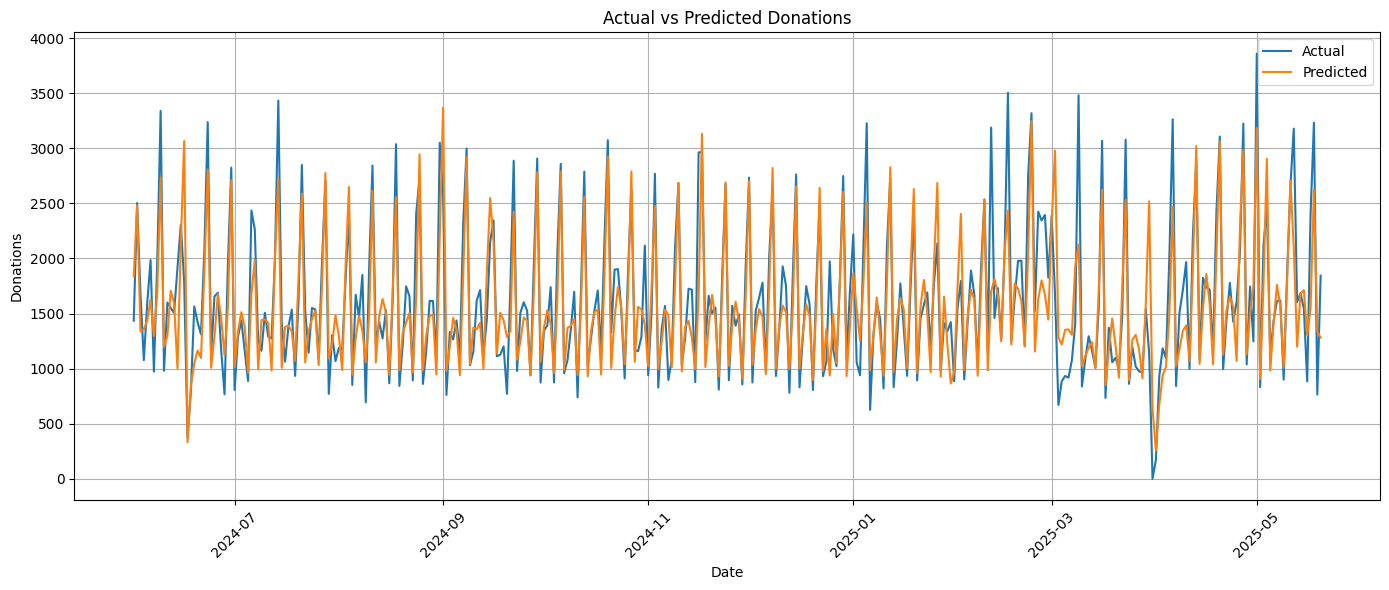

y_true,y_pred,diff,date,abs_diff
f64,f32,f64,date,f64
3188.0,1702.0,1486.0,2025-02-11,1486.0
1136.0,2518.0,-1382.0,2025-03-30,1382.0
3481.0,2127.0,1354.0,2025-03-09,1354.0
2962.0,1657.0,1305.0,2024-11-16,1305.0
1674.0,2978.0,-1304.0,2025-03-02,1304.0
…,…,…,…,…
938.0,942.0,-4.0,2024-09-27,4.0
2686.0,2684.0,2.0,2024-11-10,2.0
2535.0,2533.0,2.0,2025-02-09,2.0


In [28]:
pred_df = pl.DataFrame({'y_true': y_test_scaled.flatten(), 'y_pred': np.round(y_pred).flatten()})

pred_df = pred_df.with_columns(
    (pl.col('y_true') - pl.col('y_pred')).alias('diff')
).with_columns(
    pl.Series("date", df_all[-pred_df.height:]["date"])
)

pred_df = pred_df.with_columns(
    (abs(pl.col('diff')).alias('abs_diff'))
)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pred_df["date"], pred_df["y_true"], label="Actual")
plt.plot(pred_df["date"], pred_df["y_pred"], label="Predicted")
plt.title("Actual vs Predicted Donations")
plt.xlabel("Date")
plt.ylabel("Donations")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pred_df.sort(by='abs_diff', descending=True)

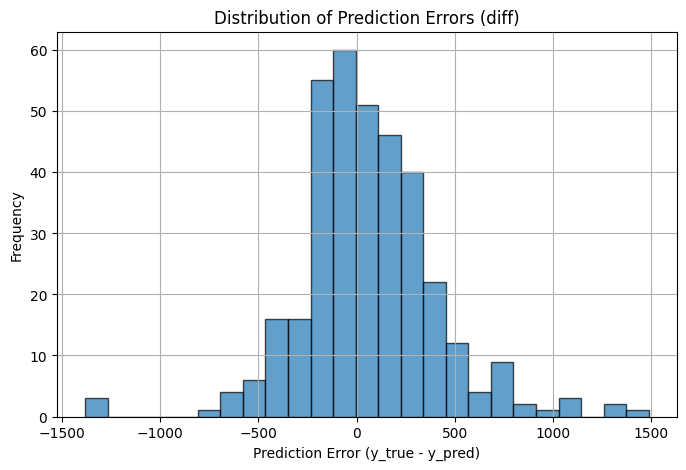

In [29]:
plt.figure(figsize=(8, 5))
plt.hist(pred_df["diff"], bins=25, edgecolor='k', alpha=0.7)
plt.title("Distribution of Prediction Errors (diff)")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()